# Dephasing noise spectroscopy by qutrits

Assume that a qutrit is surrounded by dephasing noise and affected by a sequence of pulses.
The effective Hamiltonian of such qutrit would be as follows:
\begin{equation}
H=\sum_{a=0, 1}\beta_{-a}(t)y_{-a}(t)Z^a,
\end{equation}
where $\beta_{a}(t)$ is the unknown dephasing noise function, $y_{a}(t)$ is the switching function that contains information about the characteristics of the known pulse sequence,
and Z is the generalized Pauli operator in d-dimension.

Here we call the necessary packages, and define some fixed parameters.

In [1]:
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from sympy import *
from sympy import Sum, integrate, symbols, simplify, init_printing
import scipy
import matplotlib as m
import matplotlib.pyplot as plt
from mpmath import *
mp.dps = 20; mp.pretty = True
import sys

dim=3
xi = np.round(np.exp(2*np.pi*1j/dim),6) 
wr = lambda r : 2*np.pi/(T/r)  # wn = w(r) = \omega(r) = r\omega_0 = r.w(1)

#T,M,W = 1, 10, 30 #100,100  #fig 1
#T,W = 1,30 # 3, 100,       #fig 2
T,M,W = 6, 7, 50    #fig 3   3,20 #
N = np.int(W/wr(1)) # number of Alvarez-Suter expreriments in each measurement set
rmax=N
print(N)
#N =  lambda W: np.int(W/wr(1)) 


47


Now we assume that a symmetric pulse sequence $\{ P_{r}\}_{r=1,...,2N}$ is applied to the qutrit on time instances $\{ t_{r}\}_{r=1,...,6}$ as follows:

\begin{align}
\begin{split}
\{ P_{r}\}_{r=1,...,6} &= \{ P_{1,-1}^{-1},P_{1,-1},P_{-1,0}^{-1},P_{-1,0},P_{0,1}^{-1},
P_{0,1} \}, 
\{ t_{r}\}_{r=1,...,6} &= \{ 0,t_1T/r,t_1T/r,t_2T/r,t_2T/r,T/r \}
\end{split}
\end{align}

The corresponding switching function for time interval $[0,T/r]$ is as follows

\begin{align}
\begin{split}
y_{a}(t) =1:        t\in (0,t_1T/r), 
y_{a}(t) =\xi^{-a}: t\in (t_1T/r,t_2T/r), 
y_{a}(t) =\xi^{a}:  t\in (t_2T/r,T/r),
\xi=e^{2\pi i/3}(=xi).
\end{split}
\end{align}

and coded in the following as 'yT' function.
By reapplying this reference pulse sequence to the qutrit for $M$ times, the coded switching function for time interval $[0,M.T/r]$ would be 'y'.

The corresponding filter function and its simplified forms are as follows:
\begin{align}
\begin{split}
F_{a}(\omega,t) &= \int_{0}^{t}dt'y_{a}(t')e^{i\omega t'}\\
                &=\frac{-j}{\omega}\sum_{i=1}^4f_i(a)e^{j\omega t_i(r)},\:if\:\omega \ne 0\\
                &=\sum_{i=1}^4f_i(a)t_i(r),\:if\:\omega = 0\\
          f_i(a) &\in \{ f_1(a)=-1, f_2(a)=1-\xi^{-a}, f_2(a)=\xi^{-a}-\xi^{a}, f_3(a)= \xi^{a}\},\\
          t_i(r) &\in \{ 0,t_1 T/r, t_2 T/r, T/r\}
\end{split}
\end{align}

that are coded as functions 'Ft(a,w,r)', 'fi(i,a)', and 'ti(i,r)' in the code. In addition, the tensor 'FArray' with elements 'FArray[a][k][r]' represents the function $F_{a}(k\omega_0,t)$.

We define piecewise functions in the following clear formats for better readibility.

In [2]:
t1= 1/7
t2= 2/5

def yT(a,t,r,T):  
    if   0 <= t < t1*T/r:         return 1
    elif t1*T/r <= t < t2*T/r: return xi**(-a)
    elif t2*T/r <= t < T/r:     return xi**(a)

def y(a,t,r,T):
    if   0 <= t < T/r: return yT(a,t,r,T)
    elif   t >= T/r:   return yT(a,t - floor(t/(T/r))*(T/r),r,T) 

def fi(i,a):  
    if   i==1:     return -1
    elif i==2:     return 1-xi**(-a)
    elif i==3:     return xi**(-a)-xi**(a)
    elif i==4:     return xi**(a)

def ti(i,r,T):  
    if   i==1:     return 0
    elif i==2:     return t1*T/r
    elif i==3:     return t2*T/r
    elif i==4:     return T/r

def Ft(a,w,r,T):    
    if w==0: return nsum(lambda i: fi(i,a)*ti(i,r,T),[2,4])
    else: return -(1j)/w*nsum(lambda i: fi(i,a)*exp((1j)*w*ti(i,r,T)),[1,4])

Farray = np.zeros([2,N,N],dtype=complex)
for a in range(2):
    for k in range(N):
        for r in range(N):
            Farray[a][k][r]= Ft(a+1,(k)*wr(1),r+1,T)

The assumed qutrit observables and initial states for three measurement rounds are considered as follows:

\begin{align}\label{observablesandinitialrho}
\begin{split}
\hat{O}_1 & =0.3Z^1X^1, \rho_1(0)=Z^1X^2,\\ 
\hat{O}_2 & =0.2Z^{1}X^2, \rho_2(0) = 0.7Z^2X^1,\\
\hat{O}_3 & =0.4Z^2X^1, \rho_3(0)=0.6Z^2X^2,
\end{split}
\end{align}

where $\hat{O}_{m11}$ and $\rho_{m11}(0)$ are coded as functions $O(m, n, m11)$ and $V(m, n, m11)$, respectively. The index $m11$ represents the measurement round and each round correspond to the fixed indices $(m_{m11},n_{m11})$, or for simplicity of notation $(m,n)$, that are listed below:

\begin{equation}
(m_1,n_1)=(1,1), (m_2,n_2)=(1,2), (m_3,n_3)=(2,1).
\end{equation}

For our simulation, we also need the $\lambda_{ab}^{mn}$ function as follows: 

\begin{equation}
\lambda_{ab}^{mn}= 3 O_{mn}V_{Mod(a+b-m,3),\:Mod(-n,3)} (1-\xi^{-an})(1-\xi^{-bn}) \xi^{m n}
\end{equation}

that is coded as $L(a,b,m11)$.

In [3]:
def delta(s1,s2): # kronecker delta function 
    if s1==s2: return 1
    else:      return 0
    
def O(m, n, m11):
    if    m11==0: return delta(m,1)*delta(n,1)*0.3
    elif  m11==1: return delta(m,2)*delta(n,2)*0.2
    elif  m11==2: return delta(m,1)*delta(n,2)*0.4

    
def V(m, n, m11):
    if    m11==0: return delta(m,1)*delta(n,2)*1
    elif  m11==1: return delta(m,2)*delta(n,1)*0.7
    elif  m11==2: return delta(m,2)*delta(n,1)*0.6    

def L(a,b,m11):
    if    m11==0: return 3*O(1, 1, m11)*V(fmod((a+b)-1,3),fmod(-1,3), m11)*(1-xi**(-a*1))*(1-xi**(-b*1))*xi**(1*1)
    elif  m11==1: return 3*O(2, 2, m11)*V(fmod((a+b)-2,3),fmod(-2,3), m11)*(1-xi**(-a*2))*(1-xi**(-b*2))*xi**(2*2) 
    elif  m11==2: return 3*O(1, 2, m11)*V(fmod((a+b)-1,3),fmod(-2,3), m11)*(1-xi**(-a*2))*(1-xi**(-b*2))*xi**(1*2) 

The functions $S_{\pm1,\pm1}(\omega)$ are the qutrit noise spectra in frequency domain and are consist of three even functions $x_1=R_1(\omega), x_2=I_1(\omega)$, and $x_3=E(\omega)$, that will be estimated at N different points i.e. $\omega_k=k\omega_0,\:k=0,...,N-1$ for three measurement rounds $m11=1,2,3$ each with different $\hat{O}_{m11}$ and $\rho_{m11}(0)$. Now we consider a column matrix made of these unknown three functions as follows:

\begin{align}
\begin{split}
\tilde{x}=\Big(&R_1^{1}(0),I_1^{1}(0),E^{1}(0),R_1^{1}(\omega_0),I_1^{1}(\omega_0),E^{1}(\omega_0),...,R_1^{1}((N-1)\omega_0),I_1^{1}((N-1)\omega_0),E^{1}((N-1)\omega_0)\\
&R_1^{2}(0),I_1^{2}(0),E^{2}(0),R_1^{2}(\omega_0),I_1^{2}(\omega_0),E^{2}(\omega_0),...,R_1^{2}((N-1)\omega_0),I_1^{2}((N-1)\omega_0),E^{2}((N-1)\omega_0)\\
&R_1^{3}(0),I_1^{3}(0),E^{3}(0),R_1^{3}(\omega_0),I_1^{3}(\omega_0),E^{3}(\omega_0),...,R_1^{3}((N-1)\omega_0),I_1^{3}((N-1)\omega_0),E^{3}((N-1)\omega_0)\Big), 
\end{split}
\end{align}


To be solved in a linear matrix equation $\textbf{b}=\textbf{A}\tilde{x}$, where $\textbf{A}$ is the coefficient square matrix of rank $3N$, and is arranged according to our qutrit noise spectroscopy formula as follows:

\begin{align}
\begin{split}
\textbf{A}_{n,m} &= (1/2)^{\delta_{m',0}}\delta_{m'/n',\lfloor m'/n'\rfloor} C_{m^{\prime\prime}}(e_{n^{\prime\prime}},f_{n^{\prime\prime}},m'\omega_0,T/n'),\\
n,& m \in\{0,...,3N-1\},\\
m'&= P(m,3) = \lfloor m/3 \rfloor \in \{0,...,N-1\},\\
n' &= Q(n,N)+1 = Mod(n,N)+1 \in \{1,...,N\},\\
m^{\prime\prime} &= Q(m,3) = Mod(m,3) \in \{0,...,2\},\\
n^{\prime\prime} &= P(n,N) = \lfloor n/N \rfloor \in \{1,2,3\}.
\end{split}
\end{align}

where $m'$ (or 'k' in the code) is the coefficient of $\omega_0$ that we previously considered to vary within $\{0,...,N-1\}$, $n'$ (or 'r' in the code) is the Alvarez-Suter spectroscopy round, $n^{\prime\prime}$ (or 'm11' in the code) is the measurement round, $m^{\prime\prime}$ (or 'p' in the code) is the index identifying the unknown noise function in $x_p(\omega),p=1,2,3$ defined previously as $R_1(\omega),I_1(\omega),E(\omega)$, respectively. The function $C_{m^{\prime\prime}}(e_{n^{\prime\prime}},f_{n^{\prime\prime}},m'\omega_0,T/n')$ that in the following code is called 'C(m11, k, r, p)', is defined according to the manuscript, where the  function 'Cf(a, b, w, r, m11)' is the term $\lambda_{mn}^{ab}F_a(\omega,T/r)F_{-b}^*(\omega,T/r)$ used in the definition of 'C(m11, k, r, p)'. 

the factor $(1/2)^{\delta_{m',0}}$ is equivalent to factor $\alpha$ in the final qutrit noise spectroscopy formula. In that equation, the coefficients of noise spectra for zero frequency are multiplied by 2. However in $\textbf{b}=\textbf{A}\tilde{x}$, we do not consider the term $\eta_{mn}$ when defining $\textbf{A}$ and $\textbf{b}$, and so considering the farctor $(1/2)$ for nonzero frequency terms. 
 

In [4]:
def Cf(a,b,w,r,m11,T):
    return L(a,b,m11)*Ft(a,w,r,T)*conj(Ft(-b,w,r,T))
 
def C(m11, k, r, p,T):
    if   p==0: return           (Cf(1,1,k*wr(1), r,m11,T)  + Cf(-1,-1,k*wr(1), r,m11,T))
    elif p==1: return     (1j)* (Cf(1,1,k*wr(1), r,m11,T)  - Cf(-1,-1,k*wr(1), r,m11,T))
    elif p==2: return           (Cf(1,-1,k*wr(1), r,m11,T) + Cf(-1,1,k*wr(1), r,m11,T)) 

The integral coefficients in the qutrit noise spectroscopy formula are $A(r)$: 

\begin{align}
\begin{split}
b_r &= \sum_{i=1}^3\lambda_{a,b}^{m11} I_i(a,b,r),\\
I_r &= \int_{0}^{\Omega}d\omega F_a(\omega,MT/r)F^*_{-b}(\omega,MT/r)x_i(\omega) 
\end{split}
\end{align}

we found the simplied forms of the filter functions as follows:

\begin{align}
\begin{split}
F_{a}(\omega,MT/r) &=  \int_{0.0001}^{t}dt'y_{a}(t')e^{i\omega t'}\\
&= \frac{-j}{\omega} \sum_{i=0}^3\sum_{n=0}^{M-1} f_i(a) e^{j\omega (t_i(r)+nT/r)},\:if\:\omega\ne 0
\end{split}
\end{align}

Since $\omega=0$ is practically a very small portion of the integral $I=\int_{0}^{\Omega}d\omega g(\omega)$, i.e. $\delta\omega . g(\delta\omega)$, for a significantly small amount of $\delta\omega$ if $g(\delta\omega)\ne \infty$, this portion would be close to zero and can be ignored. So we start the integral bound from for example $\delta\omega=0,0001$, and do not calculate $g(\delta\omega)$ or $F_a(0,MT/r)$.

\begin{align}
\begin{split}
b_r &= \int_{0.0001}^{\Omega}d\omega F_a(\omega,MT/r)F^*_{-b}(\omega,MT/r)x_i(\omega)\\
    &= \sum_{i_1,i_2=1}^4\sum_{n_{12}=1-M}^{M-1} f_{i_1}(a)f_{i_2}(b) \int_{0.0001}^{\Omega}d\omega \frac{x_i(\omega)}{\omega^2}e^{j\omega.h(i_1,i_2,n_1,n_2,r,T)},\\
& h(i_1,i_2,n_1,n_2,r,T)=(t_{i_1}(r)-t_{i_2}(r)) +T/r(n_{12})
\end{split}
\end{align}

If the noise spectra would be of the Poissonian form $x_i(\omega)=\omega^2 e^(-\gamma_i \omega)$, the integral ($b_r^{Pn}$) will transform to the followig form:

\begin{align}
\begin{split}
b_r^{Pn} &= \sum_{i_1,i_2=1}^4\sum_{n_{2}=1-M}^{M-1} f_{i_1}(a)f_{i_2}(b)/L(e^{L\Omega}-1),\\
&L=-\gamma+j.h(i_1,i_2,n_1,n_2,r,T)
\end{split}
\end{align}


In [5]:
def spectA1(w):
    return  0.5*exp(-0.9*(w-21)**2) + 1.5*exp(-0.06/0.7*(w-13)**2)
def spectA2(w):
    return  exp(-0.16*(w-3)**2)+exp(-0.2/0.7*(w-9)**2)+exp(-0.03*(w-14)**2)
def spectA3(w):
    return  1.5/(1+np.abs(w))
spect1  = []
spect2  = []
spect3  = []
w1 = wr(1)*np.arange(0, N-1, 0.1)
for i in range(len(w1)):
    spect1.append(spectA1(w1[i]))
    spect2.append(spectA2(w1[i]))
    spect3.append(spectA3(w1[i]))

#T = 1  
#M = 4 
#W = 20
#N = np.int(W/wr(1)) # number of Alvarez-Suter expreriments in each measurement set
#rmax=N

intfunclist = np.zeros([2*M-1,4,4,N,3], dtype=complex) 
w1increments = 300
w1list = np.linspace(0.01,W,w1increments)
for p0q0 in range(-(M-1),(M-1)+1):
    for n in range(1,4+1):
        for m in range(1,4+1):
            for r in range(1,N+1):
                for spect_num in range(1,3+1):
                        if spect_num == 1: 
                            fytList1 = [exp((-1j)*w1*((ti(n,r,T) - ti(m,r,T))+T/r*(p0q0)))*spectA1(w1)/w1**2 for w1 in w1list] 
                            intfunclist[p0q0][n-1][m-1][r-1][spect_num-1] = np.trapz(fytList1, w1list)
                        elif spect_num == 2: 
                            fytList2 = [exp((-1j)*w1*((ti(n,r,T) - ti(m,r,T))+T/r*(p0q0)))*spectA2(w1)/w1**2 for w1 in w1list]
                            intfunclist[p0q0][n-1][m-1][r-1][spect_num-1] = np.trapz(fytList2, w1list)
                        elif spect_num == 3: 
                            fytList3 = [exp((-1j)*w1*((ti(n,r,T) - ti(m,r,T))+T/r*(p0q0)))*spectA3(w1)/w1**2 for w1 in w1list]
                            intfunclist[p0q0][n-1][m-1][r-1][spect_num-1] = np.trapz(fytList3, w1list)

def CgA(a,b,r,m11,spect_num):
        return L(a,b,m11)* nsum(lambda i1,j1,p0,q0: fi(i1,a)*fi(j1,b)*intfunclist[int(p0-q0)][int(i1-1)][int(j1-1)][int(r-1)][int(spect_num-1)]\
                          ,[1,4],[1,4],[0,M-1],[0,M-1])       

def CeA(m11,r):
    return         (CgA(1,1,r,m11,1)  + CgA(-1,-1,r,m11,1)) \
            +(1j)* (CgA(1,1,r,m11,2)  - CgA(-1,-1,r,m11,2)) \
            +      CgA(1,-1,r,m11,3)  + CgA(-1,1,r,m11,3) 


P = lambda s,smax : np.int(s/smax)         
Q = lambda s,smax : np.remainder(s,smax) 
AMat1 = np.zeros([3*N,3*N], dtype=complex)      
for n in range(3*N):                    
    for m in range(3*N):
        if delta((P(m,3))/(Q(n,N)+1),floor((P(m,3))/(Q(n,N)+1)))!= 0: 
                AMat1[n][m] = (0.5**(delta(P(m,3),0)))*M*wr(Q(n,N)+1) * C(P(n,N), P(m,3), Q(n,N)+1, Q(m,3),T)

bA = np.zeros([3*N], dtype=complex) 
for n in range(3*N):
    m11 = P(n,N) 
    r1 = Q(n,N)+1  
    bA[n] = CeA(m11,r1)

#bA = [CeA(P(n,N),Q(n,N)+1)   for n in range(3*N)]    

C:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


47


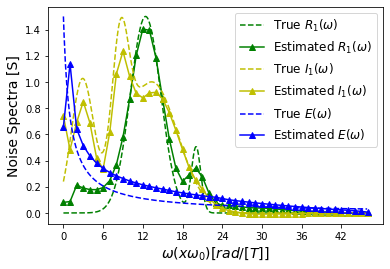

In [13]:
xA = np.linalg.lstsq(AMat1,bA)
resultA = np.real(xA[0])

R1 = []
I1 = []
E  = []
for n in range(0, 3*N,3):
    R1.append(resultA[n+0])
    I1.append(resultA[n+1])
    E.append(resultA[n+2])
omega = []
for n in range((N)):
    omega.append(n*wr(1))

print(N)        
plt.plot(w1, spect1,'g--',omega, R1 ,'g-^',w1, spect2, 'y--', omega, I1 ,'y-^', w1, spect3, 'b--', omega, E ,'b-^') 
plt.xlabel('$\omega( x\omega_0)[rad/[T]]$', fontsize=14)
plt.xticks(np.arange(0, (N)*wr(1), step=T*wr(1)),np.arange(0,N,step=T))
plt.ylabel('Noise Spectra [S]', fontsize=14)
plt.legend(['True $R_1(\omega)$','Estimated $R_1(\omega)$','True $I_1(\omega)$',\
            'Estimated $I_1(\omega)$','True $E(\omega)$','Estimated $E(\omega)$'],\
          prop={'size': 12})
plt.show()